<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/verification/image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Regression

Here we map CASA 6 image tasks to the equivalent CNGI functionality and show that the resulting numerical output is the same


installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
running tclean to generate an image
converting Image...
compatible components:  ['image', 'image']
separate components:  []
processed image size [250 250   1  10] in 0.77157426 seconds


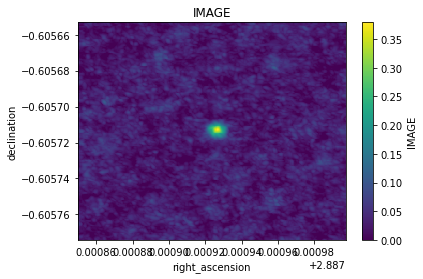

In [1]:
import os, warnings
warnings.simplefilter("ignore", category=RuntimeWarning)  # suppress warnings about nan-slices
print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")
os.system("pip install cngi-prototype==0.0.48")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

from casatasks import tclean
from cngi.conversion import convert_image
from cngi.image import implot
import numpy as np
print("running tclean to generate an image")
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='',
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, savemodel='modelcolumn',
       usemask='auto-multithresh')

image_xds = convert_image('sis14_twhya_calibrated_flagged.image', artifacts=['image'])
implot(image_xds.IMAGE, axis=['right_ascension', 'declination'])

## imsubimage

copy all or part of an image to a new image

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [50 50  1 10] in 0.2978835 seconds


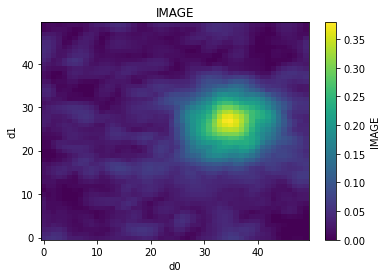

In [2]:
from casatasks import imsubimage

# CASA6
imsubimage('sis14_twhya_calibrated_flagged.image', outfile='casa6.subimage.image', box='85,100,134,149', overwrite=True)

casa_xds = convert_image('casa6.subimage.image')
implot(casa_xds.IMAGE)

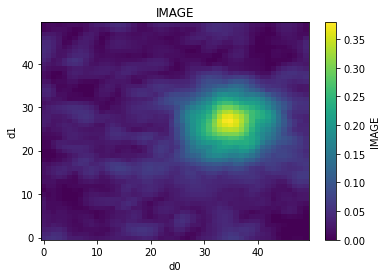

In [3]:
# CNGI
cngi_xds = image_xds.isel(d0=range(85,135), d1=range(100,150)) 
implot(cngi_xds.IMAGE)

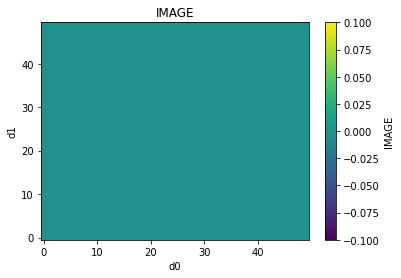

delta :  0.0


In [4]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())

## imtrans

reorders (transposes) the axes in the input image to the specified order


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.56597304 seconds


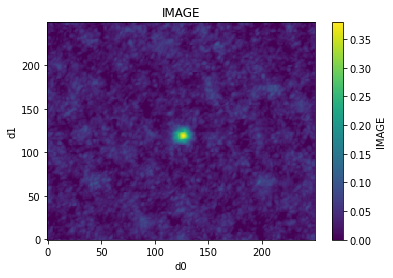

In [5]:
from casatasks import imtrans

# CASA6
os.system("rm -fr casa6.trans.image")
imtrans('sis14_twhya_calibrated_flagged.image', outfile='casa6.trans.image', order='1023')

casa_xds = convert_image('casa6.trans.image')
implot(casa_xds.IMAGE)

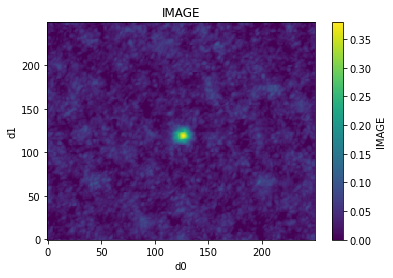

In [6]:
# CNGI
cngi_xds = image_xds.transpose('d1','d0','chan','pol')
implot(casa_xds.IMAGE)

In [7]:
# Delta
# note that CNGI keeps track of coordinate names and doesn't transpose 
# the names themselves, so we have to diff the raw numpy values
print('delta : ', np.abs(casa_xds.IMAGE.values - cngi_xds.IMAGE.values).max())

delta :  0.0


## imcollapse

collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1   1] in 0.08773732 seconds


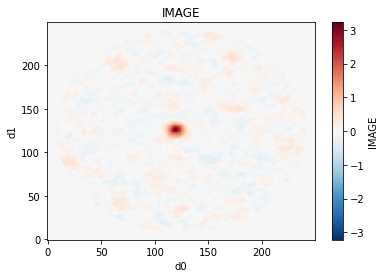

In [8]:
from casatasks import imcollapse

# CASA6
imcollapse('sis14_twhya_calibrated_flagged.image', function='sum', axes=[2,3], outfile='casa6.collapse.image', overwrite=True)

casa_xds = convert_image('casa6.collapse.image')
implot(casa_xds.IMAGE)

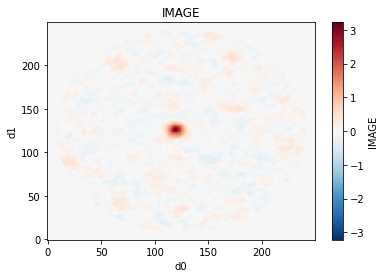

In [9]:
# CNGI
cngi_xds = image_xds.where(image_xds.MASK).sum(dim=['chan','pol'])
implot(cngi_xds.IMAGE)

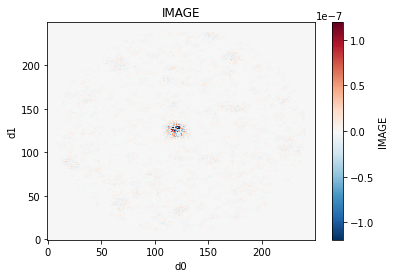

delta :  1.1920928955078125e-07


In [10]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())

## makemask


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.33686352 seconds


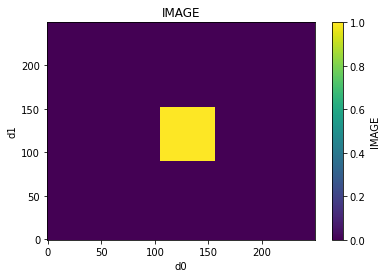

In [11]:
from casatasks import makemask

# CASA6
makemask(mode='copy', inpimage='sis14_twhya_calibrated_flagged.image', inpmask='box[[2.887905rad, -0.60573rad], [2.887935rad, -0.60570rad]]', 
         output='casa6.makemask.image', overwrite=True)

casa_xds = convert_image('casa6.makemask.image')
implot(casa_xds.IMAGE)

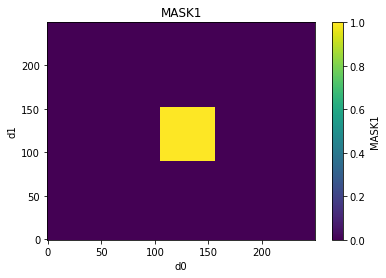

In [12]:
#CNGI
from cngi.image import region

# note that CASA swaps the meaning of 0/1 between regions and masks, CNGI does not
# so replicating the values of a CASA mask requires us to use a CNGI region
cngi_xds = region(image_xds, 'MASK1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

implot(cngi_xds.MASK1)

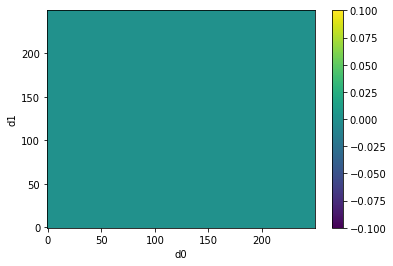

delta :  0.0


In [13]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.MASK1)
print('delta : ', np.abs((casa_xds.IMAGE - cngi_xds.MASK1).values).max())

## imrebin

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [ 83 250   1  10] in 0.45051193 seconds


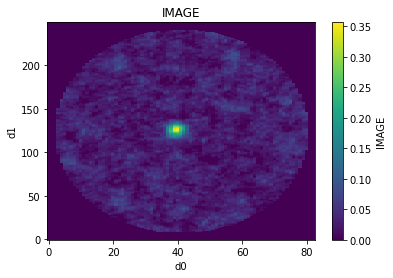

In [14]:
from casatasks import imrebin

# CASA6
imrebin(imagename='sis14_twhya_calibrated_flagged.image', outfile='casa6.rebin.image', factor=3, overwrite=True)

casa_xds = convert_image('casa6.rebin.image')
implot(casa_xds.IMAGE)

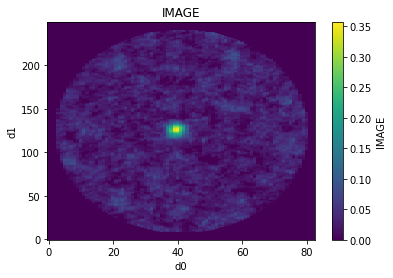

In [15]:
from cngi.image import rebin

cngi_xds = rebin(image_xds.where(image_xds.MASK), axis='d0', factor=3)
implot(cngi_xds.IMAGE)

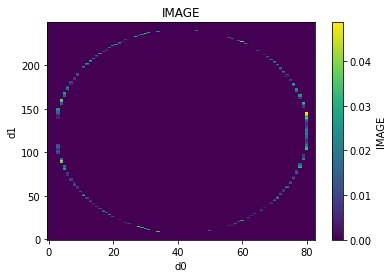

delta :  0.04867842296759288


In [16]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())

## imsmooth


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.4268515 seconds


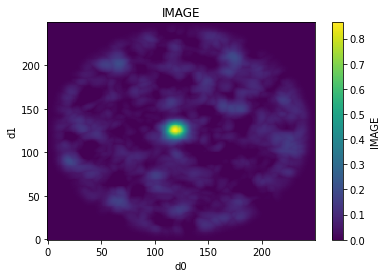

In [17]:
from casatasks import imsmooth

# CASA6
imsmooth('sis14_twhya_calibrated_flagged.image', kernel='gaussian', targetres=False, outfile='smooth.casa6.image', 
         overwrite=True, beam = {"major": "1arcsec", "minor": "1arcsec", "pa": "30deg"});

casa_xds = convert_image('smooth.casa6.image')
implot(casa_xds.IMAGE)

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:2756: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  "Passing an object to dask.array.from_array which is already a "
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:2756: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  "Passing an object to dask.array.from_array which is already a "


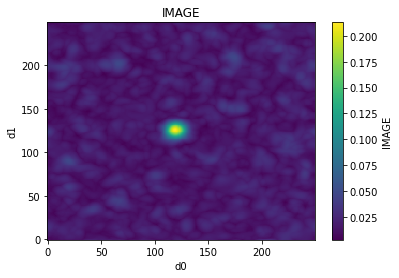

In [18]:
from cngi.image import smooth

# CNGI
#cngi_xds = smooth(image_xds.where(image_xds.MASK), kernel='gaussian', size=(1., 1., 60.), name='TARGET_BEAM')
cngi_xds = smooth(image_xds, kernel='gaussian', size=(1., 1., 60.), name='TARGET_BEAM')
implot(cngi_xds.IMAGE)

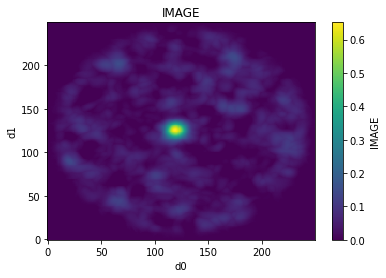

delta :  0.6515746706149138


In [19]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())

## Execute this Notebook in Colab

https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/verification/image_regression.ipynb